# Data Science
# Exercise 2 (Part 1/2: Small Data Set)
<br/>se21m024
<br/>Thomas Stummer
<br/>Small Dataset: Heart Disease
<br/><br/>
*The interpretation of the data can be found in the document <b><i>se21m024_Stummer_ex2_Dim_Reduction.pdf</i><b>.
<br/><br/>
Data taken from:
<br/>https://archive.ics.uci.edu/ml/datasets/Heart+Disease
<br/><br/>
Data Creators:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. MediMcal Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

# Import necessary dependencies

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
import math as math
import itertools as it

from sklearn.manifold import MDS
import sklearn.datasets as dt
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

pd.options.display.max_columns = None

%matplotlib inline

# Load and merge datasets

In [96]:
# Only examine processed data with a subset of 14 attributes

columns = [
    'Age', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure', 'Serum Cholestoral', 
    'Increased Blood Sugar', 'Electrocardiographic', 'Peak Heart Rate', 'Angina', 
    'ST depression', 'Peak Exercise ST Segment', 'Major Vessels', 'Thal', 'Diagnosis']

cleveland_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data', sep=',', names = columns, skipinitialspace=True)
hungarian_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data', sep=',', names = columns, skipinitialspace=True)
switzerland_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data', sep=',', names = columns, skipinitialspace=True)
va_raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data', sep=',', names = columns, skipinitialspace=True)

raw_data = pd.concat([cleveland_raw_data, hungarian_raw_data, switzerland_raw_data, va_raw_data])

# re-shuffle records just to randomize data points
#raw_data = raw_data.sample(frac=1, random_state=42).reset_index(drop=True)
raw_data.head()


,Age,Sex,Chest Pain Type,Resting Blood Pressure,Serum Cholestoral,Increased Blood Sugar,Electrocardiographic,Peak Heart Rate,Angina,ST depression,Peak Exercise ST Segment,Major Vessels,Thal,Diagnosis
0,63.0,1.0,1.0,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67.0,1.0,4.0,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67.0,1.0,4.0,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37.0,1.0,3.0,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41.0,0.0,2.0,130,204,0,2,172,0,1.4,1,0.0,3.0,0


# Show dataset features and values

In [97]:
data=raw_data

### Helper functions

def roundElementToIntSafe(y):
    try:
        return int(float(y))
    except:
        return None

def roundToInt(x):
    return x.apply(lambda value: roundElementToIntSafe(value))

def parseFloatElementSafe(y):
    try:
        return float(y)
    except:
        return None

def parseFloat(x):
    return x.apply(lambda value: parseFloatElementSafe(value)) 


### Parse columns, assign categories, remove invalid records

numericalColumns = []
categoryColumns = []
numericalCategoryColumns = []

def processColumn(data, column, isFloat=False, categoryMapping=None, categories=None):

    # Parse
    if not isFloat:
        data[column] = roundToInt(data[column])
    else:
        data[column] = parseFloat(data[column])

    # (optional) Filter records that contain one or more invalid columns
    #data = data.drop(data[data[column].isnull()].index)

    # Append to global array
    if categoryMapping is None:
        numericalColumns.append(column)
    else:
        numericalCategoryColumns.append(column)
        categoryColumn = column
        categoryColumns.append(categoryColumn)
        data[categoryColumn] = data[column].apply(categoryMapping)
    	
        # (optional) Filter records that contain one or more invalid columns
        #data = data.drop(data[data[categoryColumn].isnull()].index)

        # Add category
        data[categoryColumn] = pd.Categorical(data[categoryColumn], categories=categories)

    return data

# Age
processColumn(data=data, column='Age')

# Sex
data = processColumn(data=data, column='Sex',
categoryMapping=(lambda value: 'male' if value == 1 else 'female' if value == 0 else None), 
categories=['male', 'female'])

# Chest Pain Type
data = processColumn(data=data, column='Chest Pain Type',
categoryMapping=(lambda value: 'typical angina' if value == 1 else 'atypical angina' if value == 2 else 'non-anginal pain' if value == 3 else 'asymptomatic' if value == 4 else None), 
categories=['typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'])

#  Resting Blood Pressure [mm Hg] (in mm Hg on admission to the hospital) 
data = processColumn(data=data, column='Resting Blood Pressure')

# Serum Cholestoral in mg/dl 
data = processColumn(data=data, column='Serum Cholestoral')
# Fix Serum Cholestoral = 0
data['Serum Cholestoral'] = data['Serum Cholestoral'].apply(lambda value: value if value > 0 else None)

# Fasting Blood Sugar > 120 mg/dl
data = processColumn(data=data, column='Increased Blood Sugar',
categoryMapping=(lambda value: 'True' if value == 1 else 'False' if value == 0 else None), 
categories=['True', 'False'])

# Resting Electrocardiographic Results
data = processColumn(data=data, column='Electrocardiographic',
categoryMapping=(lambda value: 'normal' if value == 0 else 'abnormality' if value == 1 else 'hypertrophy' if value == 2 else None),
categories=['normal', 'abnormality', 'hypertrophy'])

# Maximum Heart Rate achieved 
data = processColumn(data=data, column='Peak Heart Rate')

# Exercise induced Angina
data = processColumn(data=data, column='Angina',
categoryMapping=(lambda value: 'Yes' if value == 1 else 'No' if value == 0 else None),
categories=['Yes', 'No'])

# ST depression induced by exercise relative to rest 
data = processColumn(data=data, column='ST depression', isFloat=True)

# Slope of the peak exercise ST segment
data = processColumn(data=data, column='Peak Exercise ST Segment',
categoryMapping=(lambda value: 'upsloping' if value == 1 else 'flat' if value == 2 else 'downsloping' if value == 3 else None), 
categories=['upsloping', 'flat', 'downsloping'])

# Number of major vessels (0-3) colored by flourosopy
data = processColumn(data=data, column='Major Vessels')

# Thal
data = processColumn(data=data, column='Thal',
categoryMapping=(lambda value: 'normal' if value == 3 else 'fixed defect' if value == 6 else 'reversable defect' if value == 7 else None),
categories=['normal', 'fixed defect', 'reversable defect'])

# Diagnosis of heart disease (angiographic disease status)
data = processColumn(data=data, column='Diagnosis',
categoryMapping=(lambda value: '< 50% diameter narrowing' if value == 0 else '> 50% diameter narrowing' if value == 1 else None), 
categories=['< 50% diameter narrowing', '> 50% diameter narrowing'])

data.head()



,Age,Sex,Chest Pain Type,Resting Blood Pressure,Serum Cholestoral,Increased Blood Sugar,Electrocardiographic,Peak Heart Rate,Angina,ST depression,Peak Exercise ST Segment,Major Vessels,Thal,Diagnosis
0,63,male,typical angina,145.0,233.0,True,hypertrophy,150.0,No,2.3,downsloping,0.0,fixed defect,< 50% diameter narrowing
1,67,male,asymptomatic,160.0,286.0,False,hypertrophy,108.0,Yes,1.5,flat,3.0,normal,NaN
2,67,male,asymptomatic,120.0,229.0,False,hypertrophy,129.0,Yes,2.6,flat,2.0,reversable defect,> 50% diameter narrowing
3,37,male,non-anginal pain,130.0,250.0,False,normal,187.0,No,3.5,downsloping,0.0,normal,< 50% diameter narrowing
4,41,female,atypical angina,130.0,204.0,False,hypertrophy,172.0,No,1.4,upsloping,0.0,normal,< 50% diameter narrowing


# Exploratory Data Analysis and Visualizations

## Descriptive Statistics

# Univariate Analysis

## Visualizing one dimension

### Distribution overview for categorical features

## Ex 2

In [98]:


def parseFloatElementSafe(y):
    try:
        return float(y)
    except:
        return None

def parseFloat(x):
    return x.apply(lambda value: parseFloatElementSafe(value)) 

#print(raw_data)

#b = raw_data.apply(parseFloat)
b = data
#print(b)
b = b.dropna()

# Convert to categories
for column in categoryColumns:
    b[column] = pd.factorize(b[column])[0] + 1

a = b.to_numpy()
print(len(a))
print(a)

216
[[63.  1.  1. ...  0.  1.  1.]
 [67.  1.  2. ...  2.  2.  2.]
 [37.  1.  3. ...  0.  3.  1.]
 ...
 [57.  2.  4. ...  1.  3.  2.]
 [47.  1.  2. ...  0.  2.  2.]
 [56.  1.  2. ...  0.  2.  2.]]


C:\Users\thomas.stummer\AppData\Local\Temp\ipykernel_35192\3689875842.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b[column] = pd.factorize(b[column])[0] + 1


# Algorithm 1: PCA


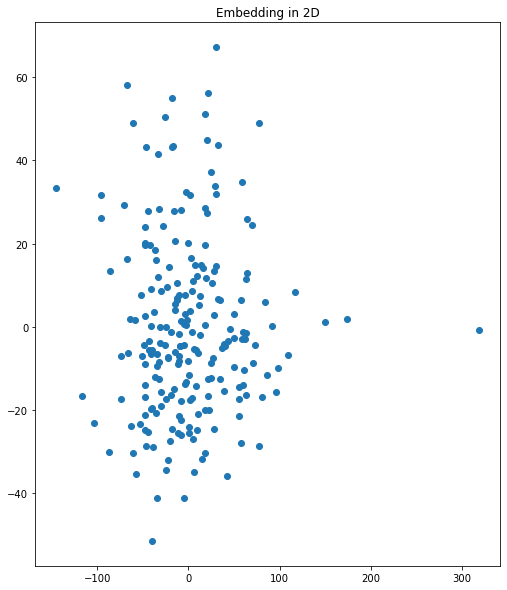

In [99]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(a)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

x = principalDf.to_numpy()
#print(x)

fig = plt.figure(2, (20,10))
# ax = fig.add_subplot(121, projection='3d')
# plt.scatter(X[:,0], X[:,1], zs=X[:,2], s=size, c=colors)
# plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(x[:,0], x[:,1])#, s=size, c=colors)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

#ax.legend(targets)
ax.grid()


# Algorithm 2: MDS


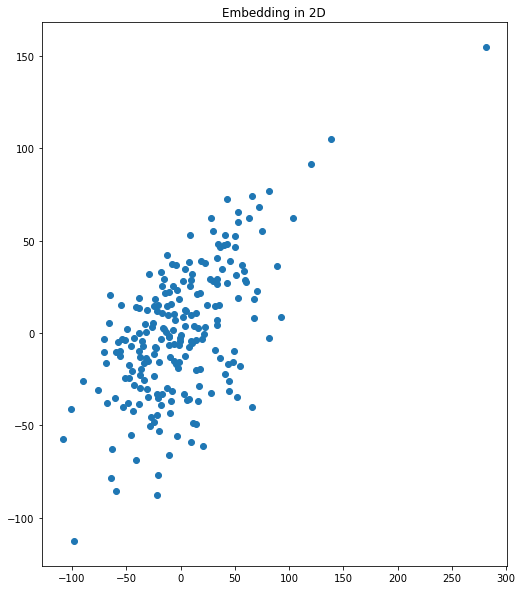

In [100]:
X = np.array(a)
mds = MDS(random_state=0)
X_transform = mds.fit_transform(X)
#print(X_transform)


#colors = ['r', 'g', 'b', 'c', 'm']
#size = [64, 64, 64, 64, 64]
fig = plt.figure(2, (20,10))
# ax = fig.add_subplot(121, projection='3d')
# plt.scatter(X[:,0], X[:,1], zs=X[:,2], s=size, c=colors)
# plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(X_transform[:,0], X_transform[:,1])#, s=size, c=colors)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()



# Algorithm 3: t-SNE


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 216 samples in 0.001s...
[t-SNE] Computed neighbors for 216 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 216 / 216
[t-SNE] Mean sigma: 18.428597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.071266
[t-SNE] KL divergence after 750 iterations: 0.421715


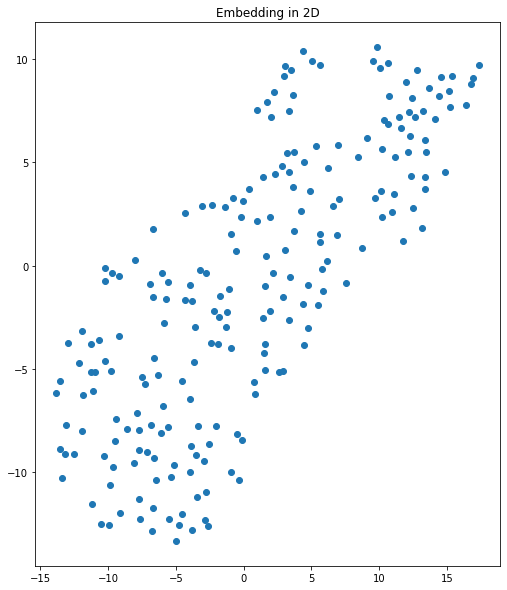

In [101]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=123)
z = tsne.fit_transform(a) 

some_data = z

fig = plt.figure(2, (20,10))
ax = fig.add_subplot(122)
plt.scatter(some_data[:,0], some_data[:,1])#, s=size, c=colors)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

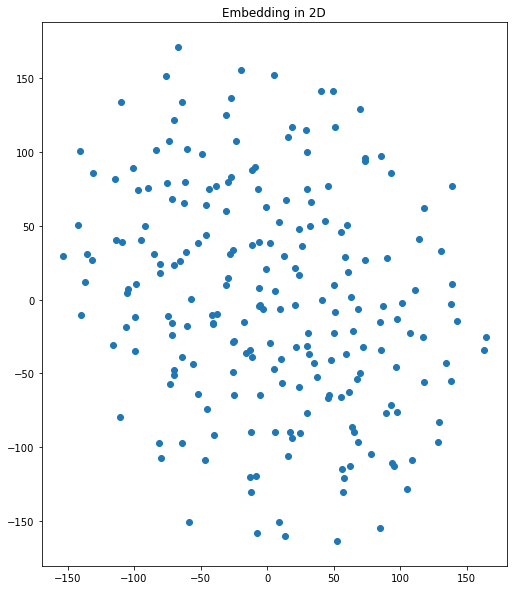

In [102]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=123)
z = tsne.fit_transform(a) 

some_data = z

fig = plt.figure(2, (20,10))
ax = fig.add_subplot(122)
plt.scatter(some_data[:,0], some_data[:,1])#, s=size, c=colors)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()